In [1]:
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
cluster=LocalCluster(dashboard_address=9090,n_workers=5,threads_per_worker=2,memory_limit='5GB')
client=Client(cluster)

/home/remy/.local/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 9090 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33009 instead
  http_address["port"], self.http_server.port


In [7]:
cluster.scheduler

<Scheduler: "tcp://127.0.0.1:45977" processes: 5 cores: 10>

In [8]:
cluster.workers

{0: <Nanny: tcp://127.0.0.1:36429, threads: 2>,
 1: <Nanny: tcp://127.0.0.1:44809, threads: 2>,
 2: <Nanny: tcp://127.0.0.1:39437, threads: 2>,
 3: <Nanny: tcp://127.0.0.1:41741, threads: 2>,
 4: <Nanny: tcp://127.0.0.1:40643, threads: 2>}

In [9]:
client

Client Scheduler: tcp://127.0.0.1:45977 Dashboard: http://127.0.0.1:33009/status,Cluster Workers: 5 Cores: 10 Memory: 25.00 GB


### Tests with pandas

In [45]:
########## With  Pandas #####
#transactions = pd.read_parquet("/media/ssd2/bitcoinRemy/tr_actor2actor_dollars.parquet",)
#transactions = pd.read_parquet("/media/ssd2/bitcoinRemy/tr_actor2actor_clean_step/part.350.parquet")
all_files = list(range(600,800))
li = []
for filenumber in all_files:
    df = pd.read_parquet("/media/ssd2/bitcoinRemy/tr_actor2actor_clean_step/part."+str(filenumber)+".parquet")
    li.append(df)
transactions = pd.concat(li, axis=0)



In [50]:
transactions

,timestamp,sender,receiver,value,day,value_Dol
date,,,,,,
2016-06-19 07:21:38,1466320898,-95049270,108721,1.306660e-11,2016-06-19,1.001904e-08
2016-06-19 07:21:38,1466320898,-95049270,-95049271,8.158977e-10,2016-06-19,6.256035e-07
2016-06-19 06:39:33,1466318373,-95049272,1505524,5.987570e-10,2016-06-19,4.591072e-07
2016-06-19 06:39:33,1466318373,-95049272,38999,4.500000e-09,2016-06-19,3.450452e-06
2016-06-19 06:59:20,1466319560,36932490,36932490,1.180000e-12,2016-06-19,9.047852e-10
...,...,...,...,...,...,...
2017-02-03 12:54:26,1486126466,-154205435,36403516,7.274780e-11,2017-02-03,7.386099e-08
2017-02-03 12:54:26,1486126466,-154205435,-154205436,1.799850e-08,2017-02-03,1.827391e-05
2017-02-03 12:46:46,1486126006,-154205437,74649,5.451015e-09,2017-02-03,5.534427e-06


In [ ]:
transactions.columns = ["timestamp","sender","receiver","value"] #Set column names

In [ ]:
transactions['date'] = pd.to_datetime(transactions['timestamp'],unit='s')

In [13]:
transactions

,timestamp,sender,receiver,value
npartitions=1135,,,,
,int64,object,object,int64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [5]:
def add_prices(df):
    prices= pd.read_csv("/media/ssd2/bitcoinRemy/btc.csv")
    prices['day'] = pd.to_datetime(prices['date'])
    prices.set_index("day")
    return dd.merge(df,prices[["day","PriceUSD"]],on="day",how="left")
def improvev_values(df):
    df["value"]=df["value"]/100000000
    df["value_Dol"]=df["PriceUSD"]*df["value"]
def create_day_column(df):
    df["day"]=df["date"].dt.floor("d")

In [6]:
def inputs_outputs_lists(df,name):
    df=df.copy()
    sent=df[df["sender"]==name][["value_Dol"]].groupby(df["day"]).sum()
    received=df[df["receiver"]==name][["value_Dol"]].groupby(df["day"]).sum()
    in_out=sent.join(received,how="outer",lsuffix="_sent",rsuffix="_received")
    return in_out
def amounts_owns(in_out):
    return ((in_out.cumsum()["value_received"]-in_out.cumsum()["value_sent"]))

In [7]:
def create_subset(name):
    return(transactions_price[(transactions_price["receiver"]==name) | (transactions_price["sender"]==name)])

In [55]:
def compute_balance(dataframe,name):
    sent=dataframe[dataframe["sender"]==name][["value"]].groupby(dataframe["day"]).sum()
    received=dataframe[dataframe["receiver"]==name][["value"]].groupby(dataframe["day"]).sum()
    in_out=sent.join(received,how="outer",lsuffix="_sent",rsuffix="_received")
    return ((in_out.cumsum()["value_received"]-in_out.cumsum()["value_sent"]))

In [56]:
def top_receivers(dataframe):
    return (dataframe.groupby(dataframe["receiver"]).sum()).sort_values("value",ascending=False)["value"]
def top_senders(dataframe):
    return (dataframe.groupby(dataframe["sender"]).sum()).sort_values("value",ascending=False)["value"]

In [10]:
def filter_out_self_spending(df):
    return df[df["sender"]!=df["receiver"]]
def filter_known_actors(df,column="both"):
    if column!="both":
        return df[~df[column].map(lambda x: x.lstrip('+-')).astype(str).str.isnumeric()]
    return df[(~df["sender"].map(lambda x: x.lstrip('+-')).astype(str).str.isnumeric()) &  (~df["receiver"].map(lambda x: x.lstrip('+-')).astype(str).str.isnumeric())]

# Time operations

In [46]:
transactions=transactions.set_index("date")
transactions.index = pd.to_datetime(transactions.index)

In [11]:
def create_static_network(df):
    df=filter_out_self_spending(df)
    return df.groupby(["sender","receiver"]).agg({'value': ['sum','count'],"value_Dol": ["sum"]})
def create_dayly_network(df):
    df=filter_out_self_spending(df)
    return df.groupby(["sender","receiver","day"]).agg({'value': ['sum','count'],"value_Dol": ["sum"]})

In [399]:

def weely_activity_by_(df,column="receiver"):
   # df["hOfW"]=
    return df.groupby([column,(df.index.dayofweek) * 24 + (df.index.hour)]).agg({'value': ['sum','count'],"value_Dol": ["sum"]})
    #df.groupby(["sender","day"]).agg({'value': ['sum','count'],"value_Dol": ["sum"]})

In [391]:
def weekly_activity_overall(df):
    return df.groupby([(df.index.dayofweek) * 24 + (df.index.hour)]).agg({'value': ['sum','count'],"value_Dol": ["sum"]})


# Usage prevalence

In [424]:
def fraction_by_nature(df):
    df["sender_nature"]="minor"
    df["sender_nature"][~df["sender"].map(lambda x: x.lstrip('-')).astype(str).str.isnumeric()]="actor"
    df["receiver_nature"]="minor"
    df["receiver_nature"][~df["receiver"].map(lambda x: x.lstrip('-')).astype(str).str.isnumeric()]="actor"
    return df

In [425]:
test = fraction_by_nature(transactions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [426]:
test

,timestamp,sender,receiver,value,date,day,value_Dol,sender_nature,receiver_nature
__null_dask_index__,,,,,,,,,
0,1466320898,-95049270,108721,1.306660e-11,2016-06-19 07:21:38,2016-06-19,1.001904e-08,minor,minor
1,1466320898,-95049270,-95049271,8.158977e-10,2016-06-19 07:21:38,2016-06-19,6.256035e-07,minor,minor
2,1466318373,-95049272,1505524,5.987570e-10,2016-06-19 06:39:33,2016-06-19,4.591072e-07,minor,minor
3,1466318373,-95049272,38999,4.500000e-09,2016-06-19 06:39:33,2016-06-19,3.450452e-06,minor,minor
4,1466319560,36932490,36932490,1.180000e-12,2016-06-19 06:59:20,2016-06-19,9.047852e-10,minor,minor
...,...,...,...,...,...,...,...,...,...
703258,1486126466,-154205435,36403516,7.274780e-11,2017-02-03 12:54:26,2017-02-03,7.386099e-08,minor,minor
703259,1486126466,-154205435,-154205436,1.799850e-08,2017-02-03 12:54:26,2017-02-03,1.827391e-05,minor,minor
703260,1486126006,-154205437,74649,5.451015e-09,2017-02-03 12:46:46,2017-02-03,5.534427e-06,minor,minor


In [429]:
grouped=test.groupby(["sender_nature","receiver_nature"]).agg({'value': ['sum','count'],"value_Dol": ["sum"]})

In [430]:
grouped

value               value_Dol
                                    sum      count          sum
sender_nature receiver_nature                                  
actor         actor            0.283929    4125402   216.081233
              minor            0.124754    6301455    87.633881
minor         actor            0.119332   11650854    83.996338
              minor            4.262841  116492649  2989.803440

In [392]:
#weekact=weely_activity(tr)
overall=weekly_activity_overall(tr)

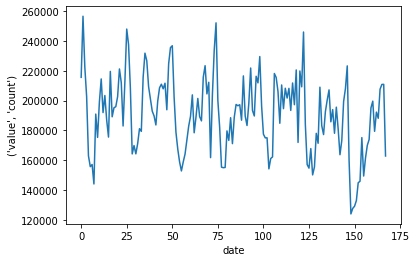

In [398]:
sns.lineplot(x=overall.index,y=overall[("value","count")])

/home/remy/.local/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [229]:
activity

date         value           value_Dol
                               sum    count        sum
receiver                                              
10xBitco.in     6671  1.118875e-07      113   0.000049
777Coin.com    14028  4.334657e-06     6808   0.002127
796.com        14028  1.621633e-04     3212   0.059059
999Dice.com    14028  2.439910e-04   471861   0.121905
AbraxasMarket  14028  5.921252e-04    93172   0.167597
...              ...           ...      ...        ...
Xapo.com       14028  1.022532e-01  7290661  45.561826
YABTCL.com     14028  2.073089e-04    15459   0.126566
YoBit.net      14028  6.732401e-04   357344   0.460663
Zyado.com      10464  4.547302e-06      310   0.002346
ePay.info      14028  1.903576e-01  4705126  80.759380

[303 rows x 4 columns]

In [376]:
most_active

Index(['999Dice.com', 'BTC-e.com', 'BTCC.com', 'BTCCPool', 'BTCJam.com',
       'BX.in.th', 'Bit-x.com', 'BitBargain.co.uk', 'BitBay.net', 'BitPay.com',
       'BitZillions.com', 'Bitbond.com', 'Bitcoin.de', 'Bitcoin.de-old',
       'BitcoinFog', 'BitcoinWallet.com', 'BitoEX.com', 'Bitstamp.net',
       'Bittrex.com', 'Bleutrade.com', 'BlockTrades.us', 'BtcTrade.com',
       'Bter.com', 'Cex.io', 'CloudBet.com', 'CoinGaming.io', 'CoinHako.com',
       'CoinJar.com', 'CoinMotion.com', 'CoinPayments.net', 'CoinSpot.com.au',
       'Coinmate.io', 'Crypto-Games.net', 'Cryptonator.com', 'Cryptopay.me',
       'Cubits.com', 'FaucetBOX.com', 'FortuneJack.com', 'FoxBit.com.br-cold',
       'HaoBTC.com', 'Hashnest.com', 'HelixMixer-old16', 'HelixMixer-old17',
       'HelixMixer-old18', 'HelixMixer-old19', 'HelixMixer-old20',
       'HelixMixer-old27', 'HelixMixer-old28', 'HelixMixer-old33',
       'HelixMixer-old34', 'HitBtc.com', 'HolyTransaction.com', 'Huobi.com-2',
       'Kraken.com', 'Loca

In [29]:
def plot_dayly(transactions,column="receiver"):
    print("filtering")
    tr=filter_known_actors(transactions,column)
    tr=filter_out_self_spending(tr)
    print("compute by hour")
    weekact=tr.groupby([column, tr.index.hour]).agg({'value': ['sum','count'],"value_Dol": ["sum"]})
    weekact2 = weekact.reset_index()
    print("keep most active")
    activity = weekact2.groupby([column]).sum(("value","count"))
    most_active=activity[activity[("value","count")]>10000].index
    print("plot")
    filtered=weekact2[weekact2[column].isin(most_active)].copy()
    filtered["transactions"]=filtered[("value","count")]
    return(filtered)
    g = sns.FacetGrid(filtered, col=column, row_order=most_active,
                  height=1.0, aspect=1, sharey=False,col_wrap=4)
    fig = g.map(sns.distplot,"date","transactions")


filtering
compute by hour
keep most active


/home/remy/.local/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


plot


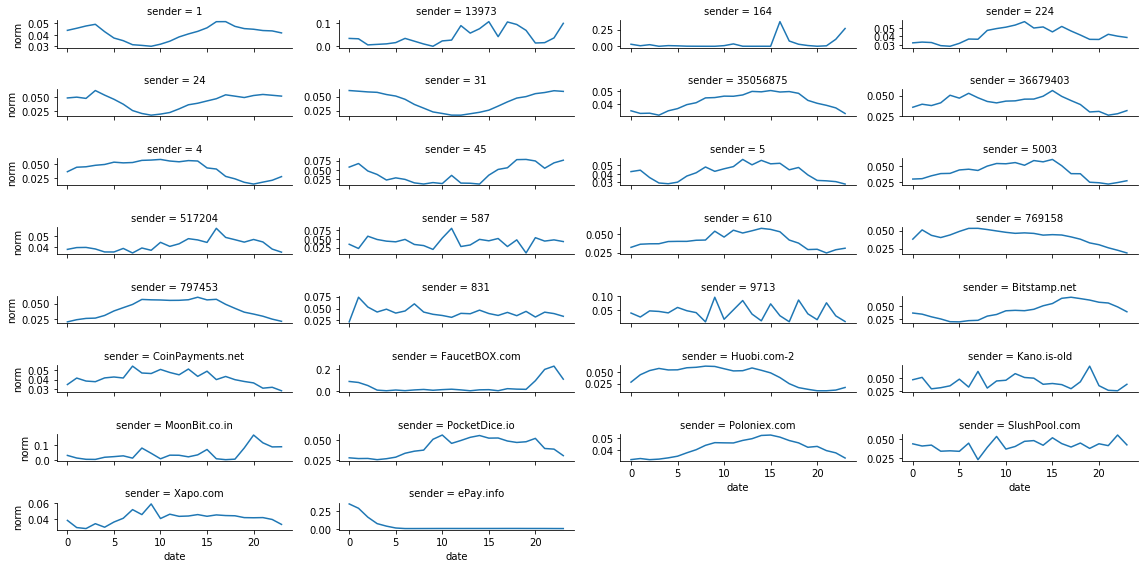

In [77]:
column="sender"
to_sum=("value","count")
overlay=True
print("filtering")
#tr=filter_known_actors(transactions,column)
tr=filter_out_self_spending(transactions)
print("compute by hour")
weekact=tr.groupby([column, tr.index.hour]).agg({'value': ['sum','count'],"value_Dol": ["sum"]})
weekact2 = weekact.reset_index()
print("keep most active")
activity = weekact2.groupby([column]).sum(to_sum)
#most_active=activity[activity[to_sum]>100000].index
most_active=activity.nlargest(30,to_sum).index
print("plot")
filtered=weekact2[weekact2[column].isin(most_active)].copy()
filtered["transactions"]=filtered[to_sum]
filtered["norm"] = filtered.groupby(column).transform(lambda x: (x / x.sum()))[[to_sum]]
if overlay:
    g = sns.FacetGrid(filtered, col=column, row_order=most_active,
              height=1.0, aspect=4, sharey=False,col_wrap=4)
    fig = g.map(sns.lineplot,"date","norm")
else:
    sns.lineplot("date","norm",data=filtered,hue=column)

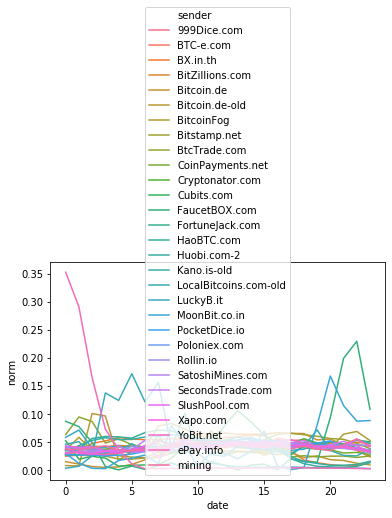

In [74]:
g= sns.lineplot("date","norm",data=filtered,hue=column)


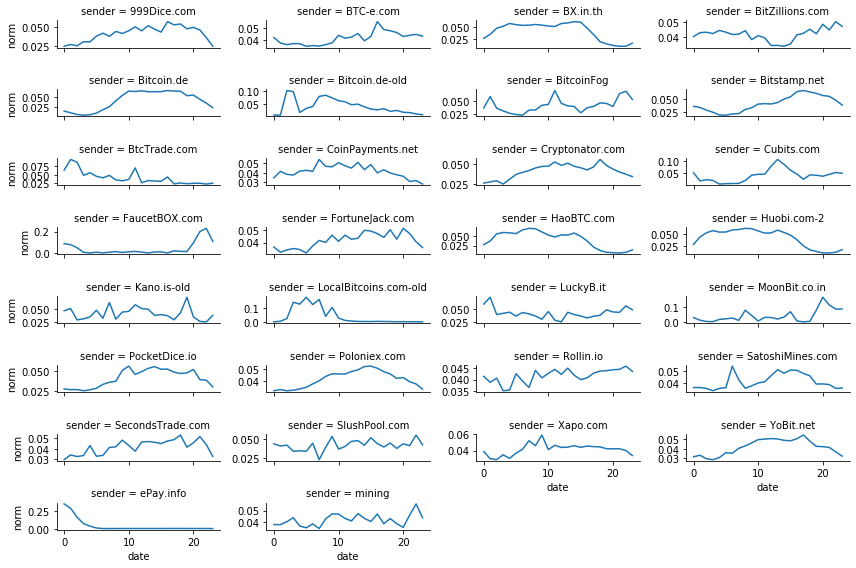

In [76]:
g = sns.FacetGrid(filtered, col=column, row_order=most_active,
          height=1.0, aspect=3, sharey=False,col_wrap=4)
fig = g.map(sns.lineplot,"date","norm")

In [58]:
most_active=activity.nlargest(10,to_sum).index



In [59]:
most_active

Index(['Xapo.com', 'Luno.com', 'Huobi.com-2', 'BTC-e.com', 'Poloniex.com',
       'Cubits.com', 'OKCoin.com', 'LocalBitcoins.com', 'CoinPayments.net',
       'BitPay.com'],
      dtype='object', name='receiver')

In [41]:
filtered

receiver date         value       value_Dol transactions      norm
                                 sum count       sum                       
31    999Dice.com    0  1.432740e-06   898  0.000948          898  0.160836
32    999Dice.com    1  4.252389e-07  1089  0.000282         1089  0.047736
33    999Dice.com    2  1.317780e-07   874  0.000087          874  0.014793
34    999Dice.com    3  1.009277e-07   482  0.000066          482  0.011330
35    999Dice.com    4  2.247829e-07   620  0.000146          620  0.025234
...           ...  ...           ...   ...       ...          ...       ...
3499    ePay.info   19  2.207280e-05  2234  0.014810         2234  0.042257
3500    ePay.info   20  2.805147e-05  1634  0.018390         1634  0.053702
3501    ePay.info   21  2.644165e-05  1651  0.017383         1651  0.050620
3502    ePay.info   22  1.898744e-05  2277  0.012555         2277  0.036350
3503    ePay.info   23  2.191876e-05  1327  0.014685         1327  0.041962

[816 rows x 7 columns]

/home/remy/.local/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [30]:
plot_dayly(transactions,"sender")

filtering
compute by hour
keep most active
plot


/home/remy/.local/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [412]:
def plot_weekly(transactions,column="receiver"):
    print("filtering")
    tr=filter_known_actors(transactions,column)
    tr=filter_out_self_spending(tr)
    print("compute by hour")
    weekact=weely_activity_by_(tr,column)
    weekact2 = weekact.reset_index()
    print("keep most active")
    activity = weekact2.groupby([column]).sum(("value","count"))
    most_active=activity[activity[("value","count")]>10000].index
    print("plot")
    filtered=weekact2[weekact2[column].isin(most_active)].copy()
    filtered["transactions"]=filtered[("value","count")]
    g = sns.FacetGrid(filtered, col=column, row_order=most_active,
                  height=1.0, aspect=4, sharey=False,col_wrap=4)
    fig = g.map(sns.lineplot,"date","transactions")

filtering
compute by hour
keep most active
plot


/home/remy/.local/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


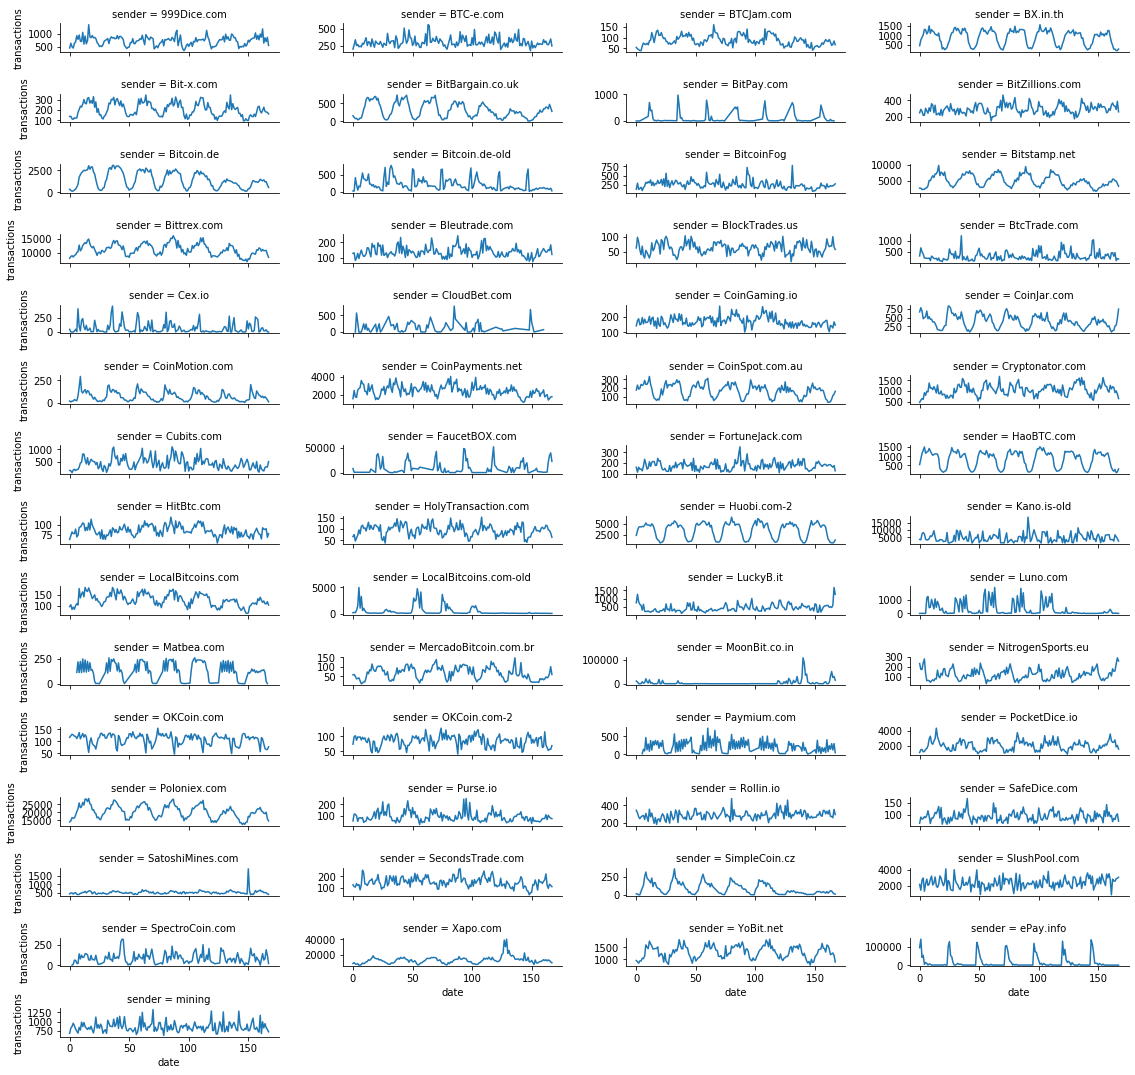

In [413]:
plot_weekly(transactions,"sender")

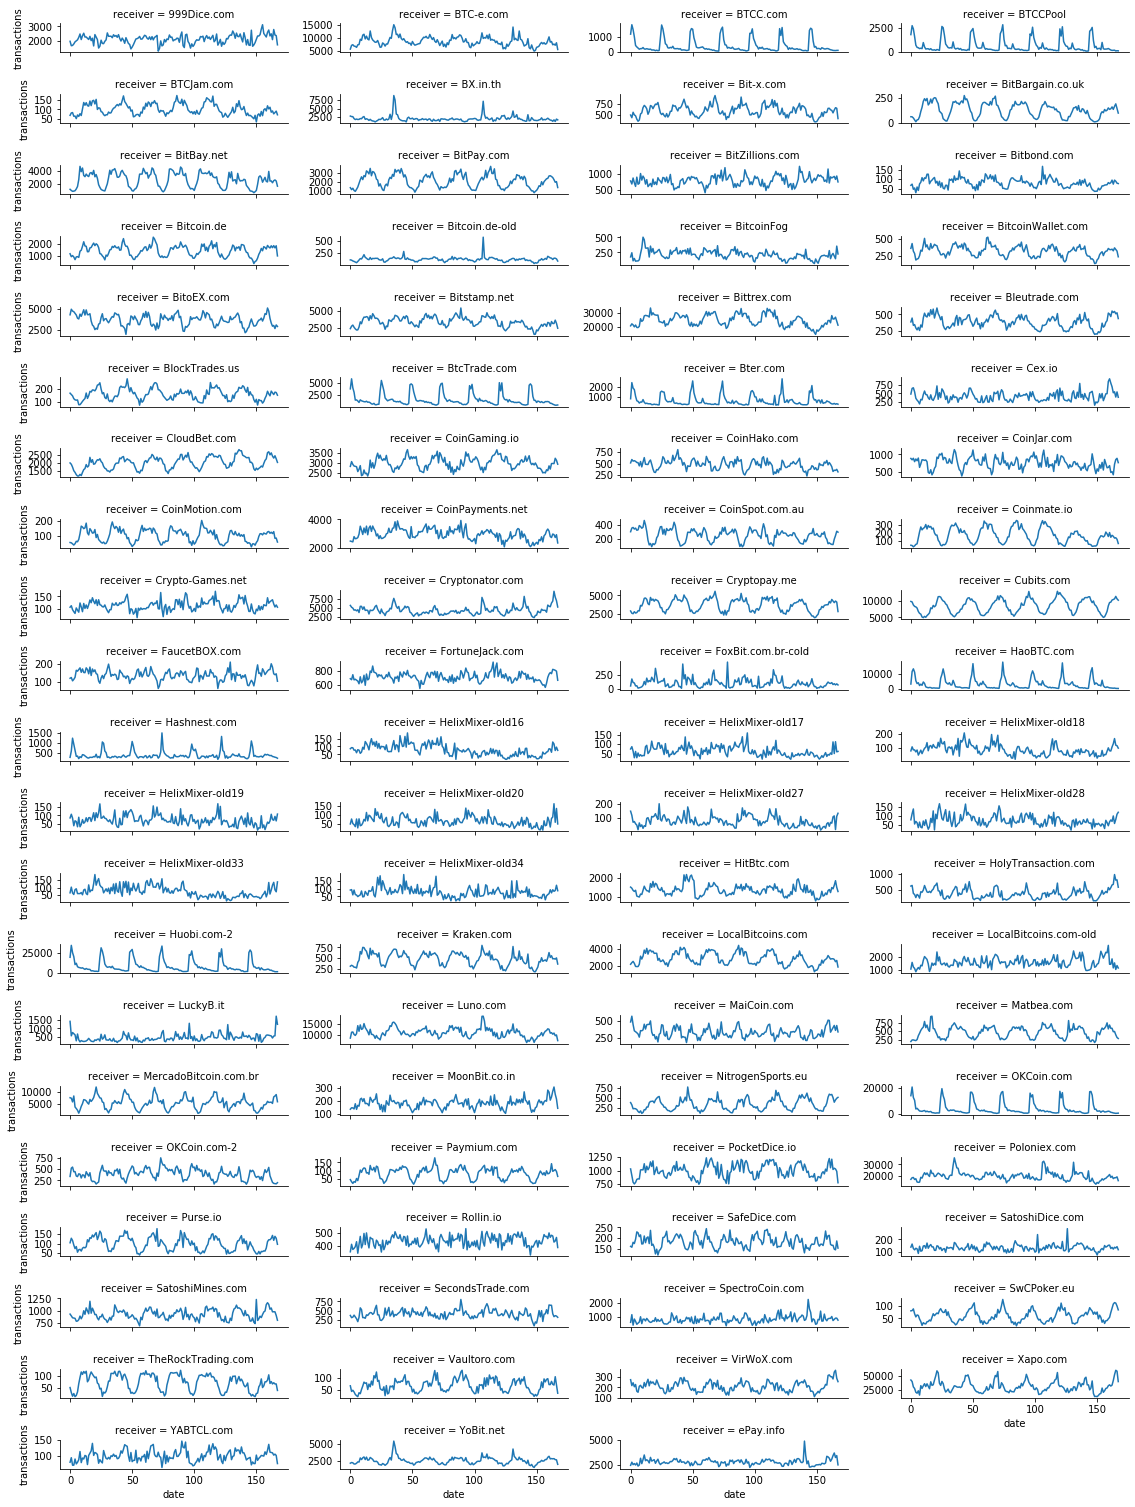

In [380]:

#fig.update_yaxes(matches=None)

# compute typical patterns

In [381]:
wide = filtered.pivot("receiver","date","transactions")

In [382]:
from sklearn.decomposition import NMF
model = NMF(n_components=4, init='random', random_state=0,max_iter=10000)
W = model.fit_transform(wide.to_numpy())
H = model.components_

In [383]:
typical=pd.DataFrame(H)

In [384]:
typical["category"]=typical.index

In [385]:

patterns= pd.melt(typical, id_vars=['category'], value_vars=typical.columns.values.tolist()[:-1],
        var_name='date', value_name='count')

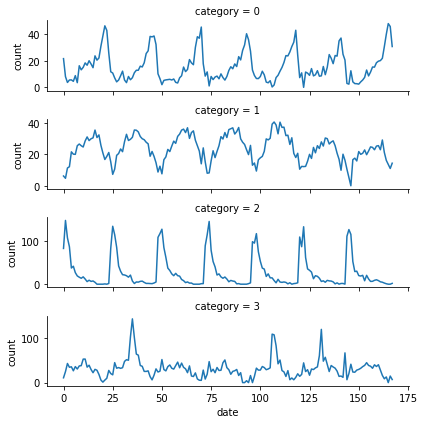

In [386]:
g = sns.FacetGrid(patterns, col="category", row_order=most_active,
                  height=1.5, aspect=4, sharey=False,col_wrap=1)
fig = g.map(sns.lineplot,"date","count")

In [390]:
pd.concat([pd.DataFrame(W).reset_index(),wide.reset_index()],ignore_index=True,axis=1).tail(60)

,0,1,2,3,4,5,6,7,8,9,...,164,165,166,167,168,169,170,171,172,173
23,23,11.065050,3.589452,3.277753,1.897281,Cex.io,480,653,671,548,...,492,865,945,815,702,518,549,388,545,381
24,24,41.966918,41.285773,11.840347,1.842378,CloudBet.com,2010,1928,1752,1530,...,2265,2648,2703,2516,2633,2436,2312,2455,2265,2044
25,25,53.745767,60.348040,20.369002,3.873429,CoinGaming.io,2842,3082,2945,2861,...,2675,2629,2868,2708,2983,2988,2980,3247,3144,2952
26,26,3.421808,11.055934,3.011859,2.502786,CoinHako.com,516,589,554,564,...,569,474,523,484,433,331,358,354,377,322
27,27,13.205772,9.957698,5.578717,5.003253,CoinJar.com,886,847,891,795,...,622,632,683,490,512,424,721,853,890,767
28,28,1.037980,3.094170,0.000000,0.400856,CoinMotion.com,55,53,46,38,...,112,126,129,117,124,115,128,83,85,58
29,29,39.631659,75.533114,13.726283,5.267445,CoinPayments.net,2488,2458,2433,2798,...,3202,3328,3188,2801,2735,2979,2939,2739,2934,2357
30,30,2.737579,3.452788,2.076052,2.175578,CoinSpot.com.au,302,354,362,340,...,196,133,145,131,123,121,197,247,309,296
31,31,0.000000,7.589483,0.000000,0.016131,Coinmate.io,51,47,31,43,...,191,158,207,149,173,161,139,143,124,72
32,32,2.308925,2.283694,0.537884,0.240488,Crypto-Games.net,107,113,97,89,...,113,145,123,129,133,137,120,108,116,107


In [ ]:
df.reset_indexe

In [324]:
wide

date,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
receiver,,,,,,,,,,,,,,,,,,,,,
999Dice.com,2557,1930,2006,1954,2320,2274,2480,2715,2823,2711,...,3318,4565,3602,3476,3451,3106,4472,4111,4496,3768
AlphaBayMarket,3417,3294,2925,3047,2917,2678,2237,2211,2148,2187,...,1892,2437,2498,3281,3099,3208,3933,3575,3238,3527
BTC-e.com,5794,6783,8867,7657,7214,6767,7286,7408,9119,8582,...,7330,9535,11155,10238,7920,7152,7696,6561,7288,6220
BTCC.com,2695,4355,6870,5857,4392,4326,4178,3952,3843,3485,...,3819,3079,2754,1893,1398,1212,845,582,669,1075
BTCCPool,3551,5656,10848,8385,5536,5223,5348,4705,4523,4027,...,4541,3994,3290,2252,1510,1504,1209,730,967,1360
BX.in.th,2463,3834,4545,3280,2904,2756,2616,2713,3010,2694,...,2732,2823,2524,2154,1723,1495,1342,1152,1571,1735
BitBay.net,348,323,374,297,205,276,351,728,930,849,...,722,588,847,728,637,661,631,578,455,282
BitPay.com,1363,1152,1302,1060,964,1186,1436,1822,2222,2543,...,2457,2377,2648,2674,2580,2508,2239,1959,2027,1379
BitPay.com-old2,1638,1541,1295,1326,1146,1272,1229,1752,2527,2845,...,2462,2680,2483,2895,2519,2147,2880,2166,1924,2202


In [6]:
transactions=dd.read_csv("/media/ssd2/bitcoinRemy/tr_actor2actor.tsv", blocksize=25e6,sep="\t",dtype={'-1': 'object'})

In [7]:
transactions.columns = ["timestamp","sender","receiver","value"] #Set column names

In [13]:
transactions= dd.read_parquet("/media/ssd2/bitcoinRemy/tr_actor2actor_parquet_test/")

In [6]:
#transactions= dd.read_parquet("/media/ssd2/bitcoinRemy/tr_actor2actor_dollars_index.parquet/")

In [8]:
transactions.to_parquet("/media/ssd2/bitcoinRemy/tr_actor2actor_parquet_test")

In [17]:
transactions=filter_out_self_spending(transactions)

In [12]:
create_day_column(transactions)

In [17]:
transactions.head()

,timestamp,sender,receiver,value,date,value_Dol,day
0,1231473279,mining,-2,50.0,2009-01-09 03:54:39,NaN,2009-01-09
1,1231469665,mining,-3,50.0,2009-01-09 02:54:25,NaN,2009-01-09
2,1231469744,mining,-4,50.0,2009-01-09 02:55:44,NaN,2009-01-09
3,1231470988,mining,-5,50.0,2009-01-09 03:16:28,NaN,2009-01-09
4,1231006505,mining,-6,50.0,2009-01-03 18:15:05,NaN,2009-01-03


In [13]:
transactions=create_dayly_network(transactions)

In [178]:
#df = transactions.compute()

In [23]:
sample = tr.sample(n = 1000000) 

In [32]:
sample

,timestamp,sender,receiver,value,date,value_Dol
day,,,,,,
2017-03-22,1490218223,-169521602,-169521604,14.271990,2017-03-22 21:30:23,14804.371680
2015-08-07,1438914127,-51184961,13157,0.000010,2015-08-07 02:22:07,0.002795
2017-08-17,1502990031,36669993,176,0.001568,2017-08-17 17:13:51,6.757262
2014-03-24,1395657007,ePay.info,-22805864,0.000177,2014-03-24 10:30:07,0.103298
2015-05-23,1432377050,164,34763630,0.056446,2015-05-23 10:30:50,13.488538
...,...,...,...,...,...,...
2016-06-26,1466901551,36913753,Xapo.com,0.000030,2016-06-26 00:39:11,0.018913
2017-04-10,1491815552,-175299233,-175299234,8.769603,2017-04-10 09:12:32,10625.688377
2016-04-28,1461875967,-84619130,-84619131,0.430427,2016-04-28 20:39:27,194.148375


In [33]:
dayly=create_dayly_network(sample)

In [34]:
dayly

value           value_Dol
                                                 sum count           sum
sender     receiver            day                                      
-100000392 1283                2016-07-13   0.000033     1      0.021659
-100000562 -100000563          2016-07-13   0.034140     1     22.475510
-100000877 -100000969          2016-07-13   0.000036     1      0.023700
           34779752            2016-07-13   0.000036     1      0.023700
           HolyTransaction.com 2016-07-13   0.000036     1      0.023700
...                                              ...   ...           ...
mining     ePay.info           2017-03-16  14.632701     1  17237.625860
                               2017-08-19  14.606438     1  60767.638631
                               2017-09-06  14.476012     1  66698.466787
                               2017-09-16  13.562792     1  50334.698040
                               2017-10-31  12.946059     1  83223.931381

[969360 rows x 3 columns]

In [20]:
len(transactions)

768963716

In [107]:
SR2 = create_subset("SilkRoad2Market")
SR = create_subset("SilkRoadMarketplace")



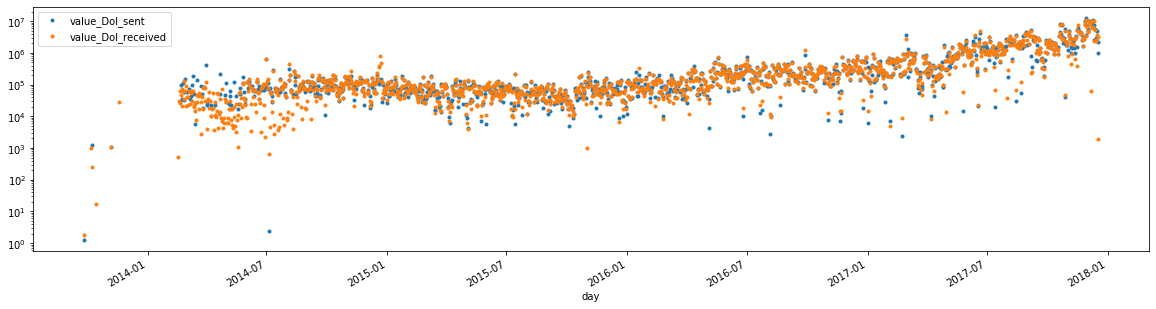

In [66]:
#in_out.div(100000000).plot(logy=True,figsize=(20,5),style=".")
in_out.plot(logy=True,figsize=(20,5),style=".")

In [46]:
Paymium2[(Paymium2["date"]>="2017-02-11") & (Paymium2["date"]<="2017-02-12")].head(50)
#df[(df['date'] > '2013-01-01') & (df['date'] < '2013-02-01')]

,timestamp,sender,receiver,value,date,value_btc
541902056,1486786799,-156762959,Paymium.com,39060,2017-02-11 04:19:59,0.000391
541957045,1486796208,-156787869,Paymium.com,100000,2017-02-11 06:56:48,0.001000
542032215,1486809408,-156819858,Paymium.com,951400,2017-02-11 10:36:48,0.009514
542033804,1486808935,6351888,Paymium.com,45732080,2017-02-11 10:28:55,0.457321
542053926,1486810341,164,Paymium.com,3900991,2017-02-11 10:52:21,0.039010
542056056,1486810341,164,Paymium.com,1447889,2017-02-11 10:52:21,0.014479
542071203,1486815585,-156833777,Paymium.com,29918368,2017-02-11 12:19:45,0.299184
542094952,1486818351,-156842480,Paymium.com,1300000,2017-02-11 13:05:51,0.013000
542103454,1486818579,Paymium.com,-156845931,5040000,2017-02-11 13:09:39,0.050400
542103455,1486818579,Paymium.com,-156845932,4910000,2017-02-11 13:09:39,0.049100


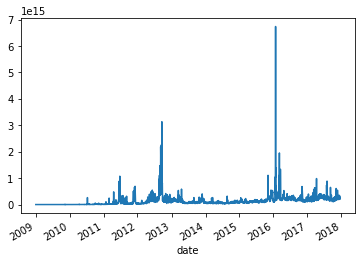

In [21]:
transactions.groupby(transactions["date"].dt.floor("d")).sum()["value"].plot()

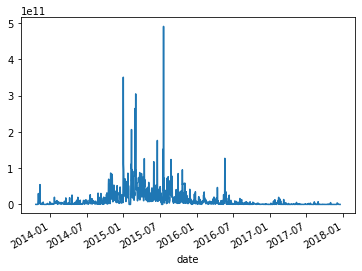

In [29]:
Lucky.groupby(Lucky["date"].dt.floor("d")).sum()["value"].plot()

In [3]:
sumUsers = transactions.groupby("sender").size()

In [10]:
#Print the sum of values sent by user
sumUsers.names=["sender","count"]

In [11]:
sumUsers.sort_values("count", ascending=[False]).head()

ValueError: No axis named count for object type Series

In [17]:
users = pd.DataFrame(sumUsers)

In [23]:
users = users.sort_values(0, ascending=[False])

In [26]:
users.head(20)

,0
sender,
ePay.info,30871984
SatoshiDice.com-original,12860377
1,10268566
FaucetBOX.com,7931086
Xapo.com,6722856
31,4916518
Poloniex.com,4729166
45,4364562
MoonBit.co.in,4246798


In [6]:
transactions["tr"]=sumUsers

In [7]:
transactions.head()

,timestamp,sender,receiver,value,date,tr
0,1231473279,mining,-2,5000000000,2009-01-09 03:54:39,NaN
1,1231469665,mining,-3,5000000000,2009-01-09 02:54:25,NaN
2,1231469744,mining,-4,5000000000,2009-01-09 02:55:44,NaN
3,1231470988,mining,-5,5000000000,2009-01-09 03:16:28,NaN
4,1231006505,mining,-6,5000000000,2009-01-03 18:15:05,NaN
